In [64]:
# Cell 1 – imports and base paths

from pathlib import Path
import re

import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from nltk import word_tokenize, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import pickle


sns.set(style="whitegrid")

BASE_DIR = Path.cwd()                 # folder where the notebook lives
EMAIL_DIR = BASE_DIR / "emails"       # folder with .txt emails
SMS_PATH = BASE_DIR / "smsspamcollection" / "SMSSpamCollection"

print("BASE_DIR :", BASE_DIR)
print("EMAIL_DIR:", EMAIL_DIR)
print("SMS_PATH :", SMS_PATH)


BASE_DIR : /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/machine_learning_section
EMAIL_DIR: /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/machine_learning_section/emails
SMS_PATH : /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/machine_learning_section/smsspamcollection/SMSSpamCollection


In [45]:
def plot_label_distribution(series, title):
    plt.figure(figsize=(8, 4))
    order = series.value_counts().index
    sns.countplot(x=series, order=order)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_length_distribution(lengths, title, xlabel):
    plt.figure(figsize=(8, 4))
    sns.histplot(lengths, bins=50, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

In [46]:
def load_emails_from_folder(data_dir: Path) -> pd.DataFrame:
    if not data_dir.exists():
        raise FileNotFoundError(f"Email folder not found: {data_dir}")

    paths = sorted(data_dir.glob("*.txt"))
    texts = []
    labels = []

    for path in paths:
        with path.open(encoding="utf8", errors="ignore") as f:
            text = f.read()
        texts.append(text)

        name = path.name.lower()
        if "phishing" in name:
            labels.append("phishing")
        elif "malicious" in name:
            labels.append("malicious")
        elif "harmful" in name:
            labels.append("harmful")
        elif "solicited" in name:
            labels.append("solicited")
        elif "spam" in name:
            labels.append("spam")
        elif "ham" in name:
            labels.append("ham")
        else:
            labels.append("unknown")

    return pd.DataFrame({"labels": labels, "message": texts})


df_emails = load_emails_from_folder(EMAIL_DIR)
print("Emails loaded:", df_emails.shape)
print(df_emails["labels"].value_counts())

Emails loaded: (153, 2)
labels
spam         52
solicited    38
malicious    28
phishing     20
harmful      15
Name: count, dtype: int64


SMS dataset loaded: (10246, 2)
Combined dataset shape: (10399, 3)
labels
malicious    2646
spam         2428
solicited    2021
phishing     1805
harmful      1499
Name: count, dtype: int64


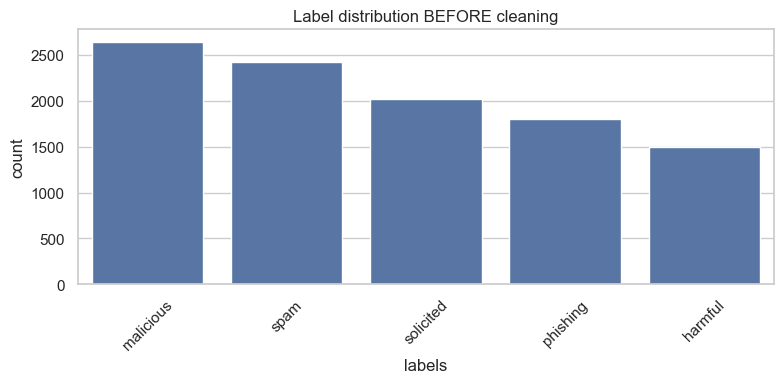

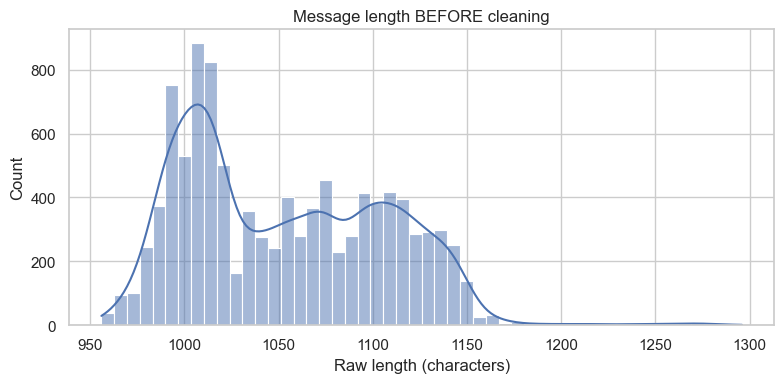

In [47]:
dfs = [df_emails]

if SMS_PATH.exists():
    df_sms = pd.read_csv(SMS_PATH, sep="\t", names=["labels", "message"])
    dfs.append(df_sms)
    print("SMS dataset loaded:", df_sms.shape)
else:
    print("SMSSpamCollection not found – using emails only.")

df = pd.concat(dfs, ignore_index=True)

df["raw_length"] = df["message"].astype(str).str.len()

print("Combined dataset shape:", df.shape)
print(df["labels"].value_counts())

plot_label_distribution(df["labels"], "Label distribution BEFORE cleaning")
plot_length_distribution(df["raw_length"], "Message length BEFORE cleaning", "Raw length (characters)")

Sample cleaned rows:
    labels                                            message  raw_length  \
0  harmful  safety filter training message sell your bank ...        1286   
1  harmful  content warning example threat text drop addre...        1251   
2  harmful  example of flagged language they should be rem...        1271   
3  harmful  abuse report sample containing phrase sell you...        1292   
4  harmful  abuse report sample containing phrase fake pas...        1253   

   clean_length  
0          1128  
1          1109  
2          1131  
3          1135  
4          1114  


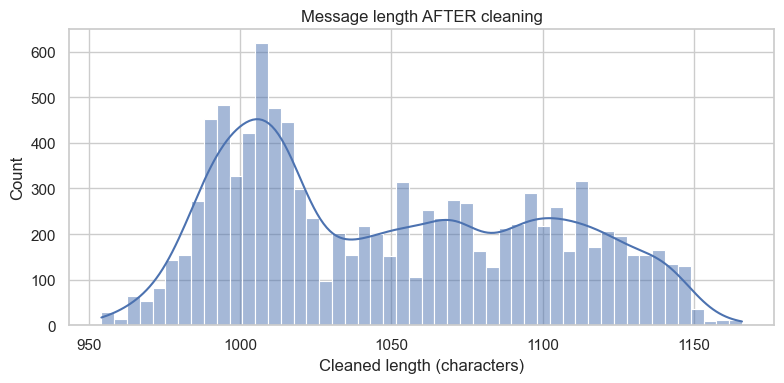

In [48]:
lemmatizer = WordNetLemmatizer()

URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
EMAIL_PATTERN = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
HEADER_PATTERN = re.compile(r"\b(subject|re|fw|fwd)\b[:\-]*", flags=re.IGNORECASE)
MARKDOWN_LINK = re.compile(r"\[.*?\]\(.*?\)")
NON_ALNUM = re.compile(r"[^a-zA-Z0-9\s]")
MULTI_SPACE = re.compile(r"\s+")


def purify_text(message: str) -> str:
    if not isinstance(message, str):
        return ""

    soup = BeautifulSoup(message, "html.parser")
    text = soup.get_text(separator=" ")

    text = MARKDOWN_LINK.sub(" ", text)
    text = URL_PATTERN.sub(" ", text)
    text = EMAIL_PATTERN.sub(" ", text)
    text = HEADER_PATTERN.sub(" ", text)

    text = text.replace("\n", " ").replace("\t", " ")
    text = NON_ALNUM.sub(" ", text)
    text = MULTI_SPACE.sub(" ", text).strip().lower()

    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if len(tok) > 1
    ]

    return " ".join(cleaned_tokens)


df["message"] = df["message"].apply(purify_text)
df["clean_length"] = df["message"].str.len()

print("Sample cleaned rows:")
print(df[["labels", "message", "raw_length", "clean_length"]].head())

plot_length_distribution(df["clean_length"], "Message length AFTER cleaning", "Cleaned length (characters)")

Train size: 8319
Test size : 2080


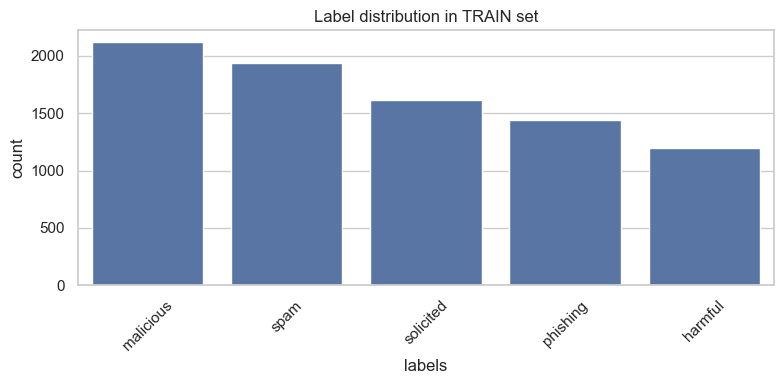

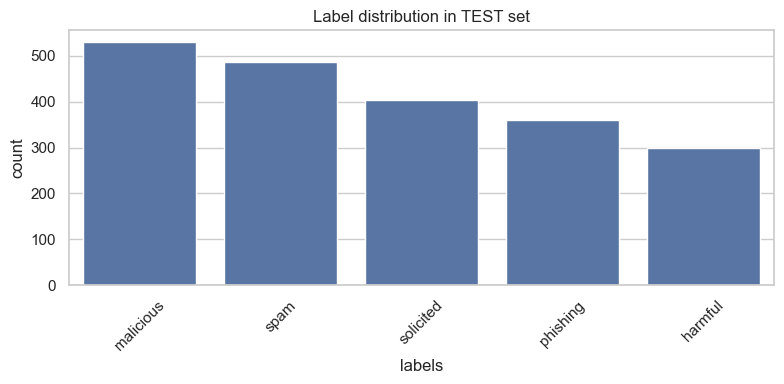

In [49]:
X = df["message"]
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

plot_label_distribution(y_train, "Label distribution in TRAIN set")
plot_label_distribution(y_test, "Label distribution in TEST set")

In [50]:
def run_model_gridsearch(name, pipeline, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n===== {name}: grid search starting =====")
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_cv_acc = grid.best_score_
    best_params = grid.best_params_

    print(f"\n{name} – best CV accuracy: {best_cv_acc}")
    print(f"{name} – best parameters:", best_params)

    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    print(f"\n{name} – TEST accuracy: {test_acc}")
    print(classification_report(y_test, y_pred))

    return {
        "name": name,
        "cv_acc": best_cv_acc,
        "test_acc": test_acc,
        "best_params": best_params,
        "model": best_model,
        "y_pred": y_pred,
    }

In [51]:
nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

nb_params = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3, 5],
    "tfidf__max_features": [None, 5000, 10000],
    "tfidf__use_idf": [True, False],
    "clf__alpha": [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1.0],
}

nb_result = run_model_gridsearch(
    "NaiveBayes",
    nb_pipeline,
    nb_params,
    X_train,
    y_train,
    X_test,
    y_test
)


===== NaiveBayes: grid search starting =====
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] END clf__alpha=1e-05, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.2s
[CV] END clf__alpha=1e-05, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.2s
[CV] END clf__alpha=1e-05, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.2s
[CV] END clf__alpha=1e-05, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.2s
[CV] END clf__alpha=1e-05, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.2s
[CV] END clf__alpha=1e-05, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time=   2.2s
[CV] END clf__alpha=1e-05, tfidf__max_features=None, tfidf__min_df=

In [52]:
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LinearSVC())
])

svm_params = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3, 5],
    "tfidf__max_features": [None, 5000, 10000],
    "tfidf__use_idf": [True, False],
    "clf__C": [0.1, 1, 10],
}

svm_result = run_model_gridsearch(
    "LinearSVC",
    svm_pipeline,
    svm_params,
    X_train,
    y_train,
    X_test,
    y_test
)


===== LinearSVC: grid search starting =====
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END clf__C=0.1, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.8s
[CV] END clf__C=0.1, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.8s
[CV] END clf__C=0.1, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.8s
[CV] END clf__C=0.1, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.8s
[CV] END clf__C=0.1, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.8s
[CV] END clf__C=0.1, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time=   2.8s
[CV] END clf__C=0.1, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf

In [53]:
logreg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000))
])

logreg_params = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3, 5],
    "tfidf__max_features": [None, 5000, 10000],
    "tfidf__use_idf": [True, False],
    "clf__C": [0.1, 1, 10],
    "clf__penalty": ["l2"],
}

logreg_result = run_model_gridsearch(
    "LogisticRegression",
    logreg_pipeline,
    logreg_params,
    X_train,
    y_train,
    X_test,
    y_test
)


===== LogisticRegression: grid search starting =====
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END clf__C=0.1, clf__penalty=l2, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.2s
[CV] END clf__C=0.1, clf__penalty=l2, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.2s
[CV] END clf__C=0.1, clf__penalty=l2, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.4s
[CV] END clf__C=0.1, clf__penalty=l2, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.4s
[CV] END clf__C=0.1, clf__penalty=l2, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=   2.4s
[CV] END clf__C=0.1, clf__penalty=l2, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__use_idf=False; total time=  

=== Model summary (CV + TEST accuracy) ===
NaiveBayes: CV accuracy=1.0000, TEST accuracy=1.0000
LinearSVC: CV accuracy=1.0000, TEST accuracy=1.0000
LogisticRegression: CV accuracy=1.0000, TEST accuracy=1.0000

Chosen final model (by CV accuracy): NaiveBayes
Final TEST accuracy: 1.0


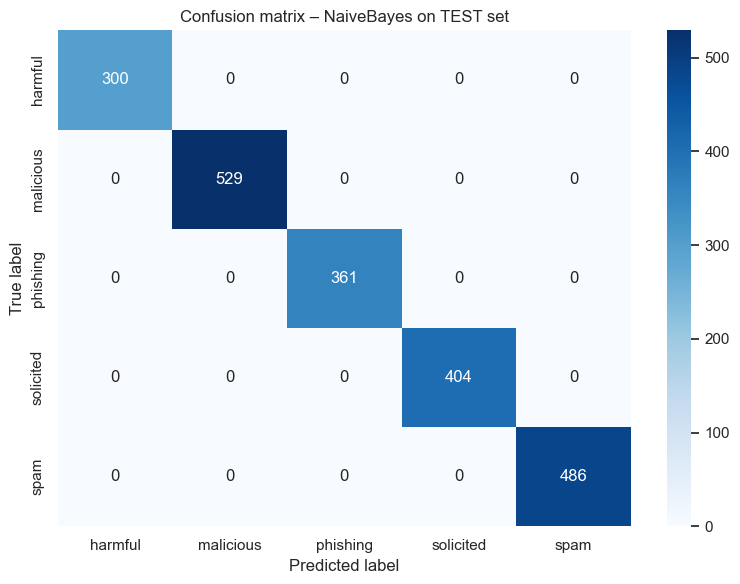

In [54]:
model_results = {
    "NaiveBayes": nb_result,
    "LinearSVC": svm_result,
    "LogisticRegression": logreg_result,
}

print("=== Model summary (CV + TEST accuracy) ===")
for name, info in model_results.items():
    print(
        f"{name}: CV accuracy={info['cv_acc']:.4f}, "
        f"TEST accuracy={info['test_acc']:.4f}"
    )

best_name = max(model_results, key=lambda k: model_results[k]["cv_acc"])
best_info = model_results[best_name]

final_model = best_info["model"]
final_y_pred = best_info["y_pred"]

print(f"\nChosen final model (by CV accuracy): {best_name}")
print("Final TEST accuracy:", best_info["test_acc"])

labels_sorted = sorted(y_test.unique())
cm = confusion_matrix(y_test, final_y_pred, labels=labels_sorted)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion matrix – {best_name} on TEST set")
plt.tight_layout()
plt.show()

In [55]:
sample_texts = [
    "Your account has been locked due to unusual activity. Click here to verify your identity.",
    "Invoice and shipping confirmation for your recent order with tracking number 12345.",
    "Limited time offer! Earn money from home with guaranteed profit and no experience needed.",
]

sample_clean = [purify_text(t) for t in sample_texts]
sample_preds = final_model.predict(sample_clean)

for text, pred in zip(sample_texts, sample_preds):
    print("\nTEXT:", text)
    print("PREDICTED LABEL:", pred)


TEXT: Your account has been locked due to unusual activity. Click here to verify your identity.
PREDICTED LABEL: phishing

TEXT: Invoice and shipping confirmation for your recent order with tracking number 12345.
PREDICTED LABEL: solicited

TEXT: Limited time offer! Earn money from home with guaranteed profit and no experience needed.
PREDICTED LABEL: spam


In [65]:
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent   # one level up; adjust if needed

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("ROOT_DIR    :", ROOT_DIR)

# main model: best model from the three
spam_clf_model_pipeline_final_second = final_model

# extra pipeline: for example, Naive Bayes baseline
ext_clf_pipeline = nb_result["model"]   # or svm_result["model"], logreg_result["model"]

# alias some apps expect
textClf = final_model

spam_model_path = ROOT_DIR / "spam_clf_model_pipeline_final_second.pkl"
ext_model_path  = ROOT_DIR / "text_clf_pipeline.pkl"
textclf_path    = BASE_DIR / "textClf.pkl"

for p in [spam_model_path, ext_model_path, textclf_path]:
    if p.exists():
        p.unlink()


for obj, p in [
    (spam_clf_model_pipeline_final_second, spam_model_path),
    (ext_clf_pipeline, ext_model_path),
    (textClf, textclf_path),
]:
    if p.exists():
        p.unlink()
    with open(p, "wb") as f:
        pickle.dump(obj, f)

# joblib.dump(spam_clf_model_pipeline_final_second, spam_model_path)
# joblib.dump(ext_clf_pipeline, ext_model_path)
# joblib.dump(textClf, textclf_path)

print("\nSaved pickle files:")
print(" -", spam_model_path)
print(" -", ext_model_path)
print(" -", textclf_path)

NOTEBOOK_DIR: /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/machine_learning_section
ROOT_DIR    : /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm

Saved pickle files:
 - /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/spam_clf_model_pipeline_final_second.pkl
 - /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/text_clf_pipeline.pkl
 - /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/machine_learning_section/textClf.pkl


In [66]:
for p in [spam_model_path, ext_model_path, textclf_path]:
    print("\nLoading:", p)
    try:
        m = joblib.load(p)
        print(" -> OK, loaded type:", type(m))
    except Exception as e:
        print(" -> FAILED to load:", repr(e))


Loading: /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/spam_clf_model_pipeline_final_second.pkl
 -> OK, loaded type: <class 'sklearn.pipeline.Pipeline'>

Loading: /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/text_clf_pipeline.pkl
 -> OK, loaded type: <class 'sklearn.pipeline.Pipeline'>

Loading: /Users/samueleko/Library/Mobile Documents/com~apple~CloudDocs/UNT/CSCE 5412/projects/spamharm/machine_learning_section/textClf.pkl
 -> OK, loaded type: <class 'sklearn.pipeline.Pipeline'>
